In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# set to be lower priority
os.nice(1) 

1

In [3]:
import warnings
warnings.simplefilter('once', RuntimeWarning)

In [4]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed

/tmp/ipykernel_126729/2156191148.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from cdcp.spiketrain_analysis.spiketrain_utils import (
    bin_interp_points,
)

In [6]:
from datetime import datetime

In [7]:
from cdcp.spiketrain_analysis.spiketrain_utils import (
    get_spike_train_vector
)

In [8]:
from cdcp.spiketrain_analysis.unit_stats.cued_similarity_and_spikevector_differences import (
    compute_cued_average_sm_rv_differences
)

In [9]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [10]:
import copy
def get_interp_points_dists_from_similarity_matrix(
    interp_points_this_unit, similarity_matrix, n_interp_point_bins=128, include_identity=False 
):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        interp_points = []
        dists = []
        mask = interp_points_this_unit > ((n_interp_point_bins / 2) - 1)
        for ri, interp_point in enumerate(interp_points_this_unit):
            maska = copy.deepcopy(mask)
            maskb = mask == False
            if include_identity == False:
                maska[ri] = False
                maskb[ri] = False
            # skip if there isn't anything to compare
            if np.sum(maska) < 1:
                continue
            if np.sum(maskb) < 1:
                continue
            interp_points.append(interp_point)

            a = np.nanmean(similarity_matrix[ri][maska])
            b = np.nanmean(similarity_matrix[ri][maskb])
            dist = a / (a + b)

            dists.append(dist)
        return interp_points, dists

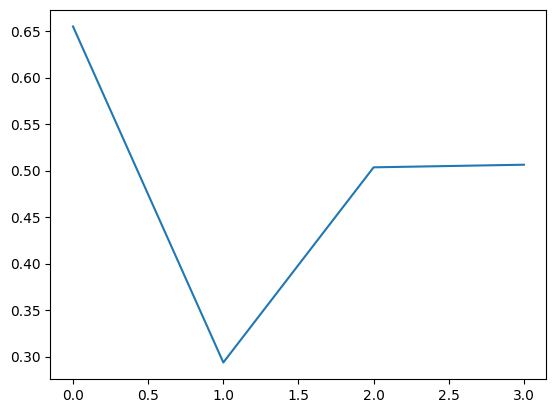

In [11]:
x = np.random.rand(4,4)
#x = np.stack([np.arange(4) for i in np.arange(4)])
#x = np.eye(4)
#x = np.arange(16).reshape(4,4)
interp_points, dists = get_interp_points_dists_from_similarity_matrix(
    np.arange(4),
    x, 
    n_interp_point_bins=4,
    include_identity=False
)
plt.plot(interp_points, dists)

In [12]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]

In [13]:
min_playbacks = 1000

In [14]:
import pandas as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter1d

from sklearn.metrics.pairwise import (
    cosine_similarity,
    euclidean_distances,
    manhattan_distances,
)

In [15]:
def get_unit_spike_trains(
    unit_recording_ids,
    spikesorting_folder,
    sorter,
    unit,
    bird,
    save_folder="trial_aligned_spikes",
):
    trial_aligned_spikes_list = []
    for unit, recording_id in tqdm(
        unit_recording_ids, desc="unit spike trains", leave=False
    ):
        trial_aligned_spikes_loc = (
            DATA_DIR
            / "spikesorting"
            / save_folder
            / bird
            / recording_id
            / "{}.pickle.zip".format(unit)
        )
        if trial_aligned_spikes_loc.exists():
            trial_aligned_spikes = pd.read_pickle(trial_aligned_spikes_loc)
            trial_aligned_spikes["recording_id"] = recording_id

            trial_aligned_spikes["stim"] = [
                i[:-4] if i[-4:].lower() == ".wav" else i
                for i in trial_aligned_spikes.stim.values
            ]

            mask = [
                (i.split("_")[-1].isnumeric() and len(i.split("_")[-1]) == 3)
                for i in trial_aligned_spikes.stim.values
            ]

            # get cue info
            trial_aligned_spikes["cue"] = [
                i.split("_")[0] if mask else np.nan
                for i, m in zip(trial_aligned_spikes.stim.values, mask)
            ]
            trial_aligned_spikes["interp"] = [
                i.split("_")[1] if mask else np.nan
                for i, m in zip(trial_aligned_spikes.stim.values, mask)
            ]

            # for i, m in zip(trial_aligned_spikes.stim.values, mask):
            #    if m:
            #        int(i.split("_")[2])
            trial_aligned_spikes["interp_point"] = [
                np.nan if m == False else int(i.split("_")[2])
                for i, m in zip(trial_aligned_spikes.stim.values, mask)
            ]
            trial_aligned_spikes_list.append(trial_aligned_spikes)
        else:
            0
            # print("{} does not have trial aligned spikes yet".format(recording_id))
            # print("\t", trial_aligned_spikes_loc)
    if len(trial_aligned_spikes_list) < 1:
        #breakme
        return None
    else:
        return pd.concat(trial_aligned_spikes_list)

In [16]:
from cdcp.spiketrain_analysis.spiketrain_utils import (
    bin_interp_points,
    get_average_response_vector,
    create_dense_similarity_matrix,
    get_similarity_matrix,
)

from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic


def compute_cued_neurometric(
    trial_aligned_spikes,
    flip_bins=True,
    n_time_bins=100,
    n_interp_point_bins=16,
    mode="constant",
):
    # ensure interp point is an integer
    trial_aligned_spikes["interp_point_binned"] = bin_interp_points(
        trial_aligned_spikes["interp_point"].values.astype(int),
        n_interp_point_bins,
        flip_bins=flip_bins,
    )

    # only look at active trials
    trial_aligned_spikes = trial_aligned_spikes[trial_aligned_spikes.passive == False]
    if len(trial_aligned_spikes) == 0:
        return

    # only get trials with a decision
    trial_aligned_spikes = trial_aligned_spikes[
        trial_aligned_spikes.response.isin(["left", "right"])
    ]

    # get average RV for each trial
    interps = trial_aligned_spikes.interp.unique()
    cues = trial_aligned_spikes.cue.unique()

    sm_dict = {}

    for interp in interps:

        # subset
        interp_trial_aligned_spikes = trial_aligned_spikes[
            (trial_aligned_spikes.interp == interp)
        ]


        # create shuffled cue condition
        interp_trial_aligned_spikes["cue_shuffled"] = interp_trial_aligned_spikes["cue"]
        for ip_bin in np.unique(interp_trial_aligned_spikes.interp_point_binned.values):
            m = (
                (interp_trial_aligned_spikes.interp_point_binned == ip_bin)
                & (interp_trial_aligned_spikes.cue.isin(["CL0", "CL1", "CR0", "CR1"]))
            ).values
            permuted_cues = list(
                np.random.permutation(interp_trial_aligned_spikes.iloc[m]["cue"].values)
            )
            interp_trial_aligned_spikes.loc[m, "cue_shuffled"] = permuted_cues

        for shuffled in [True, False]:
            if shuffled:
                cue_col = "cue"
                shuff = "true"
            else:
                cue_col = "cue_shuffled"
                shuff = "shuffled"

            for cue in cues:
                # get average response vectors
                subset_trials = interp_trial_aligned_spikes[
                    (interp_trial_aligned_spikes[cue_col] == cue)
                ]
                if len(subset_trials) < n_interp_point_bins:
                    continue
                (
                    avg_response_vectors,
                    interp_points_this_unit,
                ) = get_average_response_vector(
                    subset_trials,
                    spike_trains_col="spike_vectors",
                    interp_point_column="interp_point_binned",
                )

                if len(avg_response_vectors) < n_interp_point_bins:
                    continue

                # compute similarity matrix
                sm = create_dense_similarity_matrix(
                    avg_response_vectors,
                    interp_points_this_unit,
                    n_interp_bins=n_interp_point_bins,
                    similarity_metric="cosine",
                )

                # get logistic points
                interp_points, dists = get_interp_points_dists_from_similarity_matrix(
                    np.arange(n_interp_point_bins),
                    sm,
                    n_interp_point_bins=n_interp_point_bins,
                )

                dists = np.nan_to_num(dists)

                # fit logistic
                (
                    (_min, _max, _inflection, _slope),
                    results_logistic,
                    y_model,
                    r_squared,
                ) = fit_FourParameterLogistic(
                    interp_points,
                    dists,
                    _inflection=(n_interp_point_bins / 2) - 1,
                    _inflection_bounds=[
                        0 + int(n_interp_point_bins / 8),
                        n_interp_point_bins - 1 - int(n_interp_point_bins / 8),
                    ],
                    _min_bounds=[-1, 2],
                    _max_bounds=[-1, 2],
                )
                sm_dict[f"{interp}_{cue}_{shuff}_sm"] = sm
                sm_dict[
                    f"{interp}_{cue}_{shuff}_interp_points_this_unit"
                ] = interp_points_this_unit
                sm_dict[f"{interp}_{cue}_{shuff}_nm_min"] = _min
                sm_dict[f"{interp}_{cue}_{shuff}_nm_max"] = _max
                sm_dict[f"{interp}_{cue}_{shuff}_nm_inflection"] = _inflection
                sm_dict[f"{interp}_{cue}_{shuff}_slope"] = _slope
                sm_dict[f"{interp}_{cue}_{shuff}_r2"] = r_squared
                sm_dict[f"{interp}_{cue}_{shuff}_interp_points"] = interp_points
                sm_dict[f"{interp}_{cue}_{shuff}_dists"] = dists

    return pd.Series(sm_dict)

### Compute spike vectors and statistics

In [17]:
n_time_bins = 100
identifier = "neurometric_cue_equal_stims"

In [18]:
def get_unit_statistic(
    unit_to_analyze,
    spikesorting_folder,
    statistics_timestamp,
    bird,
    identifier=identifier,
    recompute=False,
    parallel=True,
    flip_bins=True,
    n_time_bins=100,
    gaussian_sigma_ms=25,
    save=True,
    plot=False,
):
    def run():
        unit_series_save_loc = (
            spikesorting_folder
            / "unit_statistics"
            / statistics_timestamp
            / identifier
            / "{}.pickle".format(unit_to_analyze.cluster_id)
        )

        # check if we need to run everything
        if unit_series_save_loc.exists() and (recompute is False):
            print("stat already exists")
            return

        # make sure folder exists
        ensure_dir(unit_series_save_loc)

        unit_series_list = []
        # load spike trains
        trial_aligned_spikes = get_unit_spike_trains(
            unit_to_analyze.sort_units,
            spikesorting_folder,
            sorter,
            unit_to_analyze,
            bird=bird,
            save_folder="trial_aligned_spikes_padding_100ms",
        )
        if trial_aligned_spikes is None:
            # because there are not enough spikes for this unit to be worth it
            print("no trial_aligned_spikes")
            return

        # load spike train vectors
        spiketrain_vector_loc = (
            spikesorting_folder
            / "unit_statistics"
            / statistics_timestamp
            / "response_vector_25ms_{}".format(n_time_bins)
            / "{}.npy".format(unit_to_analyze.cluster_id)
        )

        if spiketrain_vector_loc.exists() == False:
            print("no spiketrains")
            return

        trial_aligned_spikes["spike_vectors"] = list(
            np.load(spiketrain_vector_loc, allow_pickle=True)
        )

        statistic_series = compute_cued_neurometric(
            trial_aligned_spikes,
            flip_bins=flip_bins,
            n_time_bins=n_time_bins,
            # n_interp_point_bins=n_interp_point_bins,
            mode="constant",
        )
        if statistic_series is not None:
            unit_series_list.append(statistic_series)

        # skip if no data is available
        if len(unit_series_list) == 0:
            return

        # save final row
        unit_series = pd.concat(unit_series_list)

        if save:
            unit_series.to_pickle(unit_series_save_loc)

        return unit_series

    if parallel == False:
        run()
    else:
        try:
            run()
        except Exception as e:
            with open("error_log.txt", "w") as text_file:
                text_file.write(str(e))
            raise ValueError(unit_to_analyze.cluster_id)

  0%|          | 0/10 [00:00<?, ?it/s]

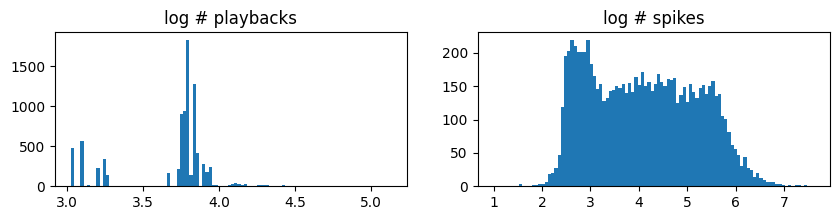

B1597 total # merged units: 8711


unit:   0%|          | 0/8711 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   16.0s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   21.6s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty S

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:   35.5s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' i

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   46.5s
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/proje

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  1.5min
/n/groups/datta/tim_sainburg/projects/

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/be

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
[Parallel(n_jobs=-1)]: Done 1642 tasks      | elapsed:  2.0min
/n/groups/datta/tim_sainburg/projects

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
[Parallel(n_jobs=-1)]: Done 2773 tasks      | elapsed:  2.4min
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 4101 tasks      | elapsed:  2.9min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 5901 tasks      | elapsed:  3.3min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 6458 tasks      | elapsed:  3.4min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 7648 tasks      | elapsed:  3.7min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. S

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

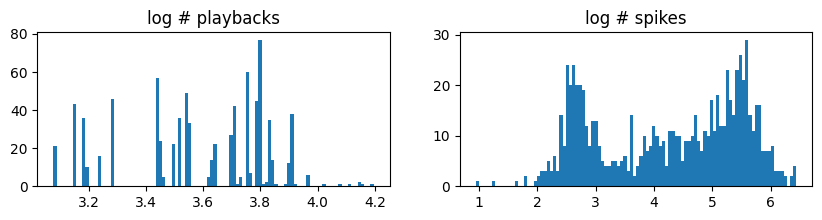

B1188 total # merged units: 821


unit:   0%|          | 0/821 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1185s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.1s
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero 

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/be

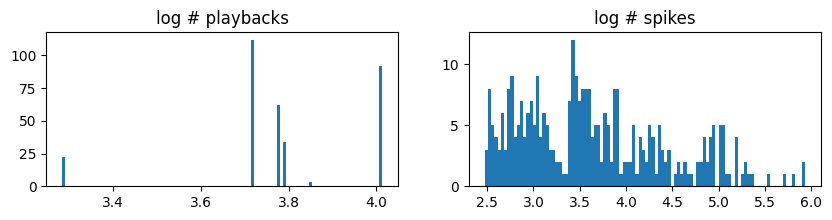

B1595 total # merged units: 325


unit:   0%|          | 0/325 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0385s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    2.0s
[P

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

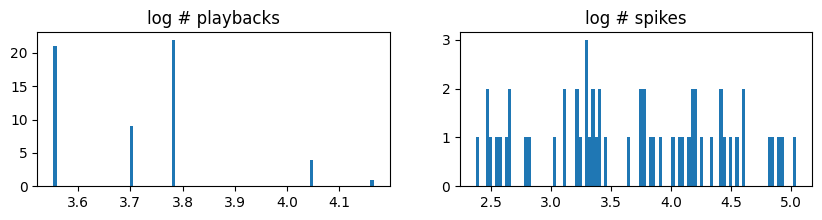

B1276 total # merged units: 57


unit:   0%|          | 0/57 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0966s.) Setting batch_size=2.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explic

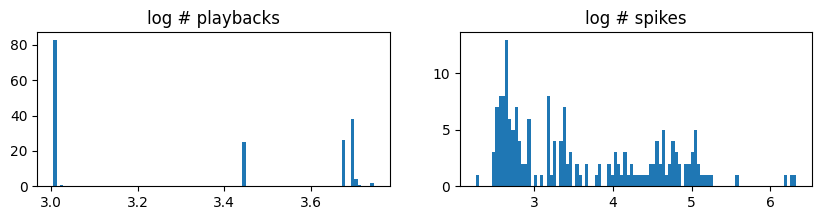

B1426 total # merged units: 180


unit:   0%|          | 0/180 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1149s.) Setting batch_size=2.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explic

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    0.8s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.8s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default 

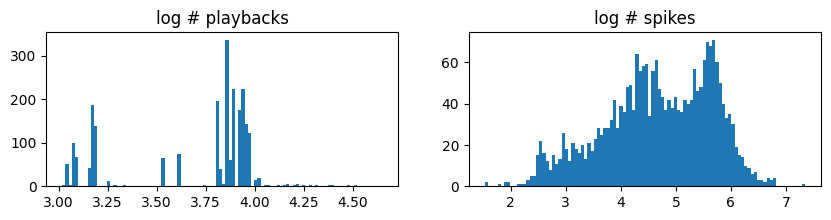

B1432 total # merged units: 2364


unit:   0%|          | 0/2364 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s


no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   22.4s



no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
uni

[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   30.0s


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   34.5s
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:   39.6s


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   41.8s


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 298 tasks      | elapsed:   45.8s
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   50.0s
/tmp/ipykernel_126729/1366431002

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 441 tasks      | elapsed:   55.3s



unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|   

[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 505 tasks      | elapsed:  1.0min
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 573 tasks      | elapsed:  1.1min
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 645 tasks      | elapsed:  1.2min
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
[Parallel(n_jobs=-1)]: Done 682 tasks 

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  1.3min
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 801 tasks      | elapsed:  1.3min
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
[Parallel(n_jobs=-1)]: Done 842 tasks      | elapsed:  1.3min


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
[Parallel(n_jobs=-1)]: Done 885 tasks      | elapsed:  1.4min
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for 

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:  1.5min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 1418 tasks      | elapsed:  1.6min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

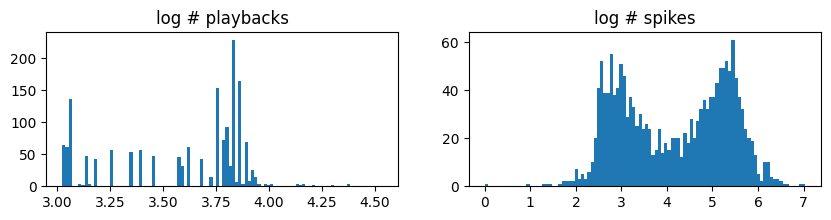

B1170 total # merged units: 1693


unit:   0%|          | 0/1693 [00:00<?, ?it/s]


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|   

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.4s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    6.1s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   12.6s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a 

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   13.6s
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:   18.1s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   18.4s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' i

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 505 tasks      | elapsed:   21.0s
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared 

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes


/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykern

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

00<?, ?it/s]
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trai

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|   

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:   28.3s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' i

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/be

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 1473 tasks      | elapsed:   37.1s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: 

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

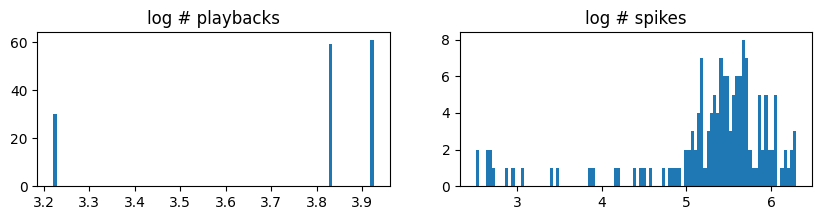

B1244 total # merged units: 150


unit:   0%|          | 0/150 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sai

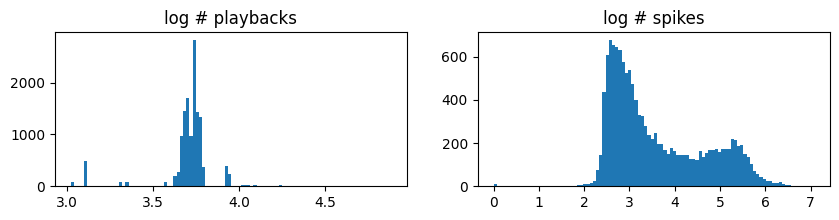

B1593 total # merged units: 13260


unit:   0%|          | 0/13260 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   16.9s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' i

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 1001 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:   30.4s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by z


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|   

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 1392 tasks      | elapsed:   38.4s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 1865 tasks      | elapsed:   46.3s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 2353 tasks      | elapsed:   56.1s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

[Parallel(n_jobs=-1)]: Done 2621 tasks      | elapsed:  1.0min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 3046 tasks      | elapsed:  1.1min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 3502 tasks      | elapsed:  1.3min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 5460 tasks      | elapsed:  2.1min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 5561 tasks      | elapsed:  2.1min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.p

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 6292 tasks      | elapsed:  2.5min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|   

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 8148 tasks      | elapsed:  3.1min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 8652 tasks      | elapsed:  3.3min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this


no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
uni

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|   

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this


no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
uni

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

[Parallel(n_jobs=-1)]: Done 11710 tasks      | elapsed:  4.2min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64'

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 11861 tasks      | elapsed:  4.3min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64'

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 13101 tasks      | elapsed:  4.6min


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

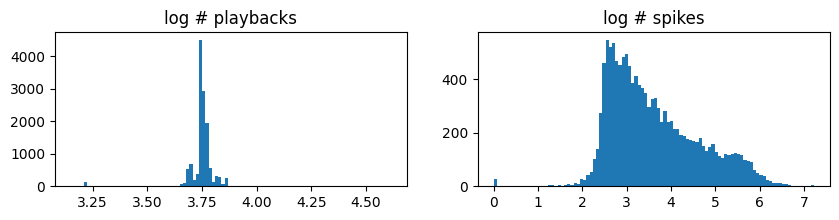

B1248 total # merged units: 13184


unit:   0%|          | 0/13184 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   12.5s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' i

[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   17.0s
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
[Parallel(n_jobs=-1)]: Done 298 tasks      | elapsed:   39.6s
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:  1.3min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/be

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:  1.6min
/n/groups/datta/tim_sainburg/projects

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be '

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:  1.8min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 2410 tasks      | elapsed:  2.0min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 2481 tasks      | elapsed:  2.0min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 3658 tasks      | elapsed:  2.5min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 3832 tasks      | elapsed:  2.6min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

[Parallel(n_jobs=-1)]: Done 5162 tasks      | elapsed:  3.1min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 5685 tasks      | elapsed:  3.3min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 6010 tasks      | elapsed:  3.4min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
[Parallel(n_jobs=-1)]: Done 8281 tasks      | elapsed:  4.3min
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/behavior/psychometric.py:86: RuntimeWarning: d

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 8410 tasks      | elapsed:  4.4min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 9760 tasks      | elapsed:  4.9min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 9901 tasks      | elapsed:  4.9min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 10618 tasks      | elapsed:  5.2min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64'


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|   

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 11361 tasks      | elapsed:  5.5min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64'

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 11512 tasks      | elapsed:  5.5min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64'

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this


no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
uni

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Done 12442 tasks      | elapsed:  5.8min
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64'

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

[Parallel(n_jobs=-1)]: Done 12921 tasks      | elapsed:  6.0min


unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/tmp/ipykernel_126729/1366431002.py:192: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this

In [19]:
for bird, timestamp, sorter in tqdm(birds):
    spikesorting_folder = (DATA_DIR
                / "spikesorting"
                / bird
                / timestamp)
    # get the summary of recordings for the bird
    recording_summary_df = pd.read_pickle(
        DATA_DIR / "spikesorting" / "recording_df" / f"{bird}.pickle.zip"
    )

    # get units that are to be merged
    merged_units = pd.read_pickle(
            DATA_DIR / "spikesorting" / "unit_clusters" / f"{bird}.pickle.zip"
        )
    merged_units = merged_units.sort_values(by='n_playbacks', ascending=False)
    merged_units = merged_units[merged_units.n_playbacks.astype('float')  > min_playbacks]
    
    plot = True
    if plot:
        fig, axs = plt.subplots(ncols=2, figsize=(10,2))
        axs[0].hist(np.log10(merged_units.n_playbacks.values.astype('float')+1), bins = 100);
        axs[0].set_title('log # playbacks')
        axs[1].hist(np.log10(merged_units.n_spikes.values.astype('float')+1), bins = 100);
        axs[1].set_title('log # spikes')
        plt.show()
        print('{} total # merged units: {}'.format(bird, len(merged_units)))

    ensure_dir(spikesorting_folder / 'unit_statistics' / statistics_timestamp)

    Parallel(n_jobs = -1, verbose=10)(
        delayed(get_unit_statistic)(
            unit_to_analyze,
            spikesorting_folder,
            statistics_timestamp,
            bird = bird,
            recompute=True,
            parallel=True,
            n_time_bins = n_time_bins
            
                    )
        for uniti, unit_to_analyze in tqdm(
            merged_units.iterrows(), desc="unit", total=len(merged_units)
        )
    );

### Debugging

In [ ]:
breakme

In [ ]:
unit_to_analyze

In [ ]:
for uniti, unit_to_analyze in tqdm(
        merged_units[:]
        .iterrows(), desc="unit", total=len(merged_units)
    ):
    if unit_to_analyze.cluster_id != 2398:
        continue
    break

In [ ]:
unit_series = get_unit_statistic(
    unit_to_analyze,
    spikesorting_folder,
    statistics_timestamp,
    bird=bird,
    recompute=True,
    parallel=False,
    save=False,
    plot=False,
)

In [ ]:
%debug

### make dataframe

In [20]:
ensure_dir(DATA_DIR / 'unit_statistics' / statistics_timestamp / identifier)

In [21]:
def read_and_unit(i):
    try:
        df = pd.read_pickle(i)
        df['unit'] = i.stem
        return df
    except:
        return

In [22]:
for bird, timestamp, sorter in tqdm(birds):
    print(bird)
    spikesorting_folder = (DATA_DIR
                / "spikesorting"
                / bird
                / timestamp)
    # get the summary of recordings for the bird
    recording_summary_df = pd.read_pickle(
        DATA_DIR / "spikesorting" / "recording_df" / f"{bird}.pickle.zip"
    )
    unit_series_save_loc = (
        spikesorting_folder / "unit_statistics" / statistics_timestamp / identifier
    )
    unit_pickles = list(unit_series_save_loc.glob("*.pickle"))
    if len(unit_pickles) == 0:
        print('\t no units')
        continue
    unit_statistics_df = pd.concat(
        Parallel(n_jobs=-1, prefer="threads")(
            delayed(read_and_unit)(i)
            for i in tqdm(unit_pickles, leave=False, desc="reading pickles")
        ),
        axis=1,
    ).T

    unit_statistics_df.to_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / identifier
        / "{}.pickle".format(bird)
    )
    

  0%|          | 0/10 [00:00<?, ?it/s]

B1597


reading pickles:   0%|          | 0/6750 [00:00<?, ?it/s]

B1188


reading pickles:   0%|          | 0/496 [00:00<?, ?it/s]

B1595


reading pickles:   0%|          | 0/114 [00:00<?, ?it/s]

B1276


reading pickles:   0%|          | 0/23 [00:00<?, ?it/s]

B1426


reading pickles:   0%|          | 0/69 [00:00<?, ?it/s]

B1432


reading pickles:   0%|          | 0/2139 [00:00<?, ?it/s]

B1170


reading pickles:   0%|          | 0/1064 [00:00<?, ?it/s]

B1244


reading pickles:   0%|          | 0/141 [00:00<?, ?it/s]

B1593


reading pickles:   0%|          | 0/7422 [00:00<?, ?it/s]

B1248


reading pickles:   0%|          | 0/8641 [00:00<?, ?it/s]

no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|    

unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/1 [00:00<?, ?it/s]
no trial_aligned_spikes
unit spike trains:   0%|          | 0/2 [00:00<?, ?it/s]
